# Tube segmentation

In [1]:
from brainlit.utils import session
from brainlit.feature_extraction import *
import napari

/Users/thomasathey/Documents/mimlab/mouselight/env/lib/python3.8/site-packages/python_jsonschema_objects/__init__.py:50: UserWarning: Schema version http://json-schema.org/draft-04/schema not recognized. Some keywords and features may not be supported.
  warnings.warn(


In [2]:
url = "s3://open-neurodata/brainlit/brain1"
sess = session.NeuroglancerSession(url=url, url_segments=url + "_segments", mip=0)
SEGLIST = [
    101,
    103,
    106,
    107,
    109,
    11,
    111,
    112,
    115,
    11,
    12,
    120,
    124,
    126,
    127,
    129,
    13,
    132,
    133,
    136,
    137,
    14,
    140,
    141,
    142,
    143,
    144,
    145,
    146,
    147,
    149,
    150,
]
SEGLIST = SEGLIST[:1]

In [3]:
# %%capture
nbr = NeighborhoodFeatures(
    url=url, radius=1, offset=[50, 50, 50], segment_url=url + "_segments"
)
nbr.fit(seg_ids=SEGLIST, num_verts=10, file_path="demo", batch_size=10)

Downloading:   0%|          | 0/1 [00:00<?, ?it/s]


In [4]:
import glob, feather

feathers = glob.glob("*.feather")


for count, feather_file in enumerate(feathers):
    if count == 0:
        data = feather.read_dataframe(feather_file)
    else:
        df = feather.read_dataframe(feather_file)
        data = pd.concat([data, df])
data.shape

(20, 30)

In [5]:
data.head()

,Segment,Vertex,Label,0,1,2,3,4,5,6,...,17,18,19,20,21,22,23,24,25,26
0,101,0,1,28778,30111,30120,28438,29909,30092,28315,...,28751,30383,30683,29420,29565,30769,29762,28865,29364,29687
1,101,0,0,12290,12090,12222,12340,12215,12376,12185,...,12208,12144,11845,12030,12682,12340,12336,12194,12383,12067
2,101,1,1,15429,16558,17587,15353,16662,17459,15462,...,18105,14926,16441,17088,15187,16712,17474,15401,16939,18366
3,101,1,0,12166,12290,12180,12162,12129,12124,12058,...,12297,12090,12038,12144,11959,11929,12116,12093,12298,12407
4,101,2,1,13005,12535,12333,12903,12660,12402,12846,...,12502,12388,12404,12471,12860,12526,12441,12951,12771,12571


In [6]:
from sklearn.preprocessing import StandardScaler

X = data.iloc[:, 3:]
X = StandardScaler().fit_transform(X)

y = data["Label"]

In [7]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)
clf = MLPClassifier(
    hidden_layer_sizes=4, activation="logistic", alpha=1, max_iter=1000
).fit(X_train, y_train)
y_score = clf.predict_proba(X_test)

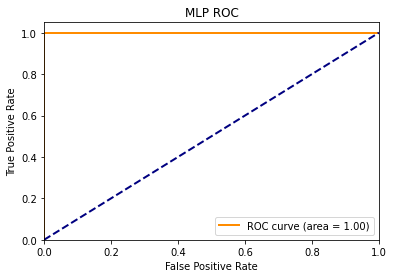

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(
    fpr, tpr, color="darkorange", lw=lw, label="ROC curve (area = %0.2f)" % roc_auc
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("MLP ROC")
plt.legend(loc="lower right")
plt.show()

In [9]:
from brainlit.feature_extraction.neighborhood import subsample

In [11]:
X.shape

(20, 27)

In [12]:
from sklearn.linear_model import LogisticRegression

Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X, y, stratify=y, random_state=1
)
clf = LogisticRegression(random_state=1, max_iter=2000).fit(Xc_train, yc_train)
yc_score = clf.predict_proba(Xc_test)

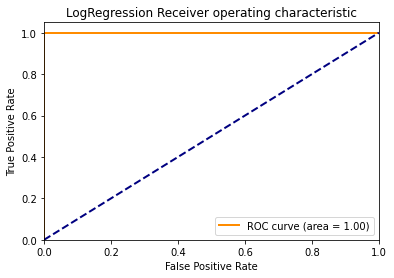

In [13]:
fpr_c, tpr_c, _ = roc_curve(yc_test, yc_score[:, 1])
roc_auc_c = auc(fpr_c, tpr_c)

plt.figure()
lw = 2
plt.plot(
    fpr_c,
    tpr_c,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc_c,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("LogRegression Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()